# **Modeling and Evaluation Regression Predict Wing Span Notebook**

## Objectives

*   Fit and evaluate a regression model to predict Wing Span for Single piston Engined airplanes.


## Inputs

* outputs/datasets/collection/airplane_performance_study.csv
* Instructions on which variables to use for data cleaning and feature engineering. They are found in their respective notebooks.

## Outputs

* feature_importance (3 files) 
* errors_analysis
* Predicted vs Actual Plot
* Residuals Distribution Plot
* Residuals vs Fitted Plot
* Train set
* Test set
* Modeling pipeline

---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* Access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/data-driven-design/jupyter_notebooks'

Make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/data-driven-design'

---

# Imports

In [4]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# Load Data

In order to not compare apples with oranges the code below filters out all Multi Engined, jet and propjet leaving only the subset of **single Piston Engines**. It drops these columns as well as the performance modification (TP mods) column and the Hmax_(One) and ROC_(One)-columns since they only pertain to Multi Engined airplane.

In [5]:
df = (pd.read_csv("outputs/datasets/collection/airplane_performance_study.csv")
      .query("Engine_Type == 0 and Multi_Engine == 0 and TP_mods == 0")  # subset of airplanes with single Piston Enginees without any Turbo Prop performance modification TP_mods dmultiple Engines
      .drop(labels=['Model', 'Company', 'THR', 'SHP', 'Engine_Type', 'Multi_Engine', 'TP_mods', 'Hmax_(One)', 'ROC_(One)'], axis=1)
      )

print(df.shape)
df.head(10)

(402, 16)


,Wing_Span,Length,Height,AUW,MEW,FW,Vmax,Vcruise,Vstall,Range,Hmax,ROC,Vlo,Slo,Vl,Sl
0,37.416667,25.250000,10.250000,2050.0,1180.0,241.2,104.000000,91.0,46.0,370.0,13000.000000,450.000000,900.000000,391.970247,1300.0,257.745075
1,36.083333,20.583333,8.750000,1350.0,820.0,100.5,89.000000,83.0,44.0,190.0,12300.000000,600.000000,720.000000,26.247647,800.0,225.324824
2,35.000000,21.416667,8.583333,1300.0,810.0,127.3,90.000000,78.0,37.0,210.0,16000.000000,650.000000,475.000000,363.139711,850.0,585.751317
3,35.000000,21.416667,8.583333,1300.0,800.0,127.3,88.000000,78.0,37.0,210.0,13000.000000,620.000000,500.000000,407.797297,850.0,642.046166
4,35.000000,21.416667,8.750000,1220.0,740.0,93.8,83.000000,74.0,33.0,175.0,12500.000000,370.000000,632.000000,297.056192,885.0,329.571813
5,36.083333,20.333333,8.750000,1250.0,786.0,100.5,78.000000,72.0,33.0,180.0,11000.000000,360.000000,583.000000,393.226454,880.0,542.445142
13,42.250000,30.000000,11.416667,6300.0,3650.0,536.0,104.000000,91.0,60.0,235.0,10186.534495,486.010839,2080.000000,1080.000000,1190.0,588.000000
14,42.416667,25.500000,11.500000,5200.0,3650.0,428.8,103.336468,100.0,52.0,200.0,6333.745675,1360.000000,1050.000000,430.000000,1150.0,565.000000
15,35.916667,24.333333,10.833333,4500.0,3160.0,308.2,128.000000,96.0,59.0,148.0,14500.000000,1600.000000,860.000000,505.000000,770.0,410.000000
16,42.250000,25.916667,26.083333,3150.0,2680.0,308.2,128.000000,91.0,52.0,155.0,16984.027272,1350.000000,1365.533522,1000.000000,540.0,1150.000000


---

## Define features and target

Define features and target

X are the features for the model (all columns in df except for target Wing_Span.
y is the target variable which is the Wing_Span column in the df.

In [6]:
# Define features and target
X = df.drop('Wing_Span', axis=1)  # Features (where I drop the target variable)
y = df['Wing_Span']  # Target variable

## Split Train Test Set

80% of df is split into the train set and 20% is left for the test set.
The random_state=0 parameter ensures reproducibility of the split.

We see that we have a suffiecent numper of data points to work with.

In [7]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)  # 80% to train and 20% to test.

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (321, 15) (321,) 
* Test set: (81, 15) (81,)


---

# MP Pipeline: Regressor

## Create Pipeline

'scaler' applies standard scaling to the (numerical) features, ensuring that they have a mean = 0 and a standard deviation = 1.
'regressor' initializes Random Forest regression model for predicting target variable (Wing_Span).

In [8]:
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),  # Scale numerical features
    ('regressor', RandomForestRegressor(random_state=0))  # Regression model using Random Forrest
])

## Fit the model

build the training model using the training dataset.

StandardScaler is applied to scale the features in X_train.

RandomForestRegressor is trained on the scaled features (from previous step) and corresponding target values.

In [9]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', RandomForestRegressor(random_state=0))])

## Make predictions

Scaling test features using StandardScaler fitted during training.

Using the trained RandomForestRegressor to predict on scaled test data.

Output: The predicted values for target (Wing_Span) stored in the predictions variable.

In [10]:
predictions = pipeline.predict(X_test)

---

## Evaluate Model Test Set

### Mean Squared Error Calculation

The mean_squared_error computes the mean squared error (MSE) between the actual values (y_test) and the predicted values (predictions). The MSE provids a quantitative measure of the model's performance on the test dataset.

 MSE is ok but not great, typically off by almost 3 ft (square root on MSE)! However we will do a cross-validation downstreams to see if this more reliable value is better.

In [11]:
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 7.269560176611815


## Print feature importances (for RandomForestRegressor)

feature_importance_df is created that in descending order (by importance) list an "importance score"-for each feature providing insights into which features are most influential in predicting the target variable (Wing_Span).It makes much sense that the weights are on top since the Wing Span is related to the Wing Area (not in the data set) and that Wing Area is directly related to lift that in turn is directly related to the weights (since the lift need to offset the weight in order for the airplane to fly)

In [12]:
importances = pipeline.named_steps['regressor'].feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
print(feature_importance_df.sort_values(by='Importance', ascending=False))

    Feature  Importance
2       AUW    0.323164
0    Length    0.249754
3       MEW    0.150723
8     Range    0.041125
1    Height    0.039843
14       Sl    0.031536
6   Vcruise    0.024841
7    Vstall    0.023296
12      Slo    0.020960
13       Vl    0.020804
5      Vmax    0.020709
4        FW    0.018682
9      Hmax    0.012260
11      Vlo    0.011164
10      ROC    0.011140


Save above output

In [13]:
# Save the feature names as a .pkl file
joblib.dump(feature_names.tolist(), 'outputs/ml_pipeline/predict_analysis/feature_names.pkl')

# Save the feature importance DataFrame as a .pkl file
joblib.dump(feature_importance_df, 'outputs/ml_pipeline/predict_analysis/feature_importance_df.pkl')


['outputs/ml_pipeline/predict_analysis/feature_importance_df.pkl']

---

## Plot Regression

### Predicted vs actual values
The points in the scatter plot represent the predicted Wing_Span values (on the y-axis) against the actual Wing_Span values (on the x-axis) for the test set.

In [14]:
print(y_test.shape)

(81,)


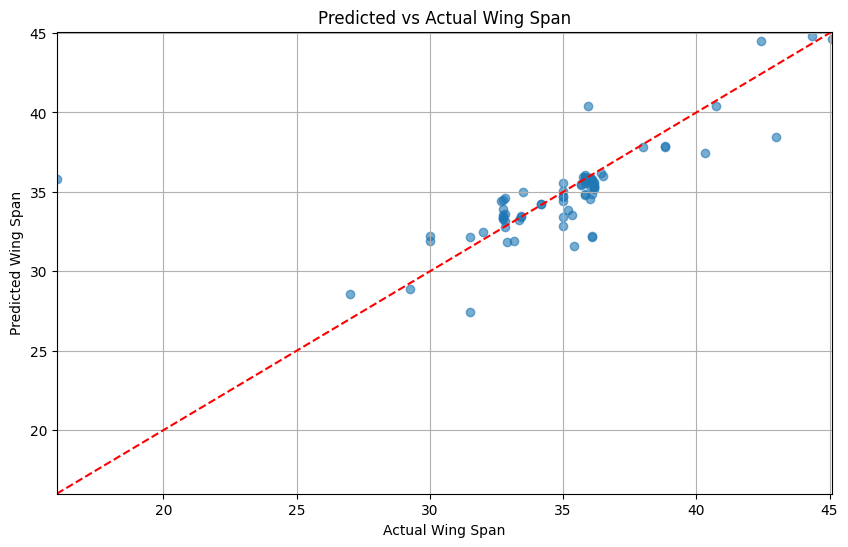

In [15]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal line
plt.title('Predicted vs Actual Wing Span')
plt.xlabel('Actual Wing Span')
plt.ylabel('Predicted Wing Span')
plt.xlim([y_test.min(), y_test.max()])
plt.ylim([y_test.min(), y_test.max()])
plt.grid()
plt.savefig('outputs/ml_pipeline/predict_analysis/predicted_vs_actual.png')  # Save the plot as a PNG file
plt.show()

### Residual plot

Calculating Residuals: The residuals are calculated by subtracting the predicted values (predictions) from the actual values (y_test). Residuals indicate the difference between what the model predicted and what the actual values were.

This histogram helps visualize the distribution of the residuals, which can indicate how well the model is performing. Ideally, residuals should be normally distributed around zero if the model is a good fit.

The Residuals Distribution shows that the distribution of errors (if negelecting the outlier) are such that all errors are all well within +- 5 meter. (and that the model rather tend overestimate than underestimate the wingspan).

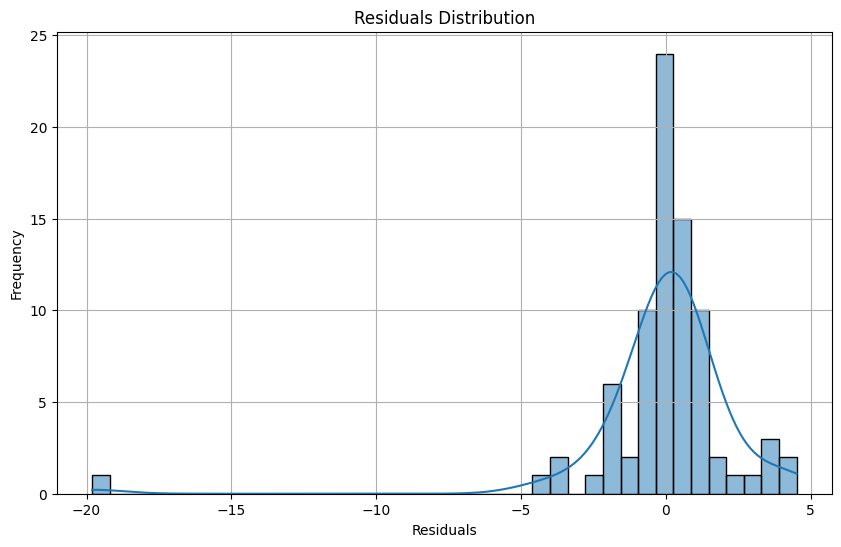

In [16]:
residuals = y_test - predictions
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid()
plt.savefig('outputs/ml_pipeline/predict_analysis/residuals_distribution.png')  # Save the plot as a PNG file
plt.show()

### Residuals vs Fitted plot

Each point represents a fitted value (predicted wingspan) from the train set plotted against its corresponding residual.

Ideally, the residuals should be randomly scattered around the horizontal line at zero without any discernible pattern however our pattern appear to be "high" which is consistent with our previous plots.

If we the "High pattern" is real it could indicate: it may indicate issues such as non-linearity, omitted variables, or model miss-specification.

We also notice an outlier at the bottom of the graf that we could hunt down and remove since it potentially could skew the data.

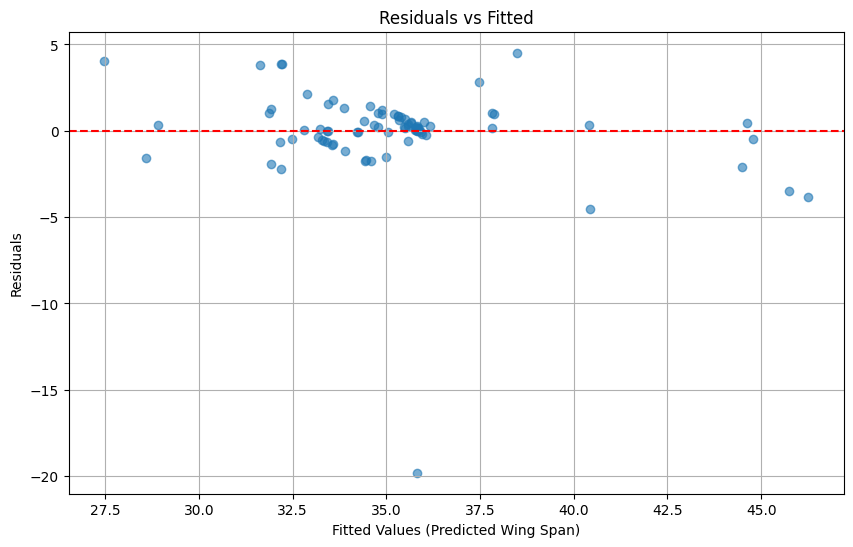

In [17]:
plt.figure(figsize=(10, 6))
plt.scatter(predictions, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Fitted')
plt.xlabel('Fitted Values (Predicted Wing Span)')
plt.ylabel('Residuals')
plt.grid()
plt.savefig('outputs/ml_pipeline/predict_analysis/residuals_vs_fitted.png')  # Save the plot
plt.show()


---

## Cross Validation with K-fold

Cross-validation gives a more reliable estimate of model performance and shows that our model is more reliable than we thought before having made the cross-validation (MSE before minus KSA after cross-validation) in MSE with 7.26.. - 4.41.. = 2,85..

In [18]:
# Define the number of folds
# The selection of 10 folds is standard for more reliable estimates especially if the size of the data set allows which it does in our case.
#
n_folds = 10 

# Initialize KFold cross-validator
kf = KFold(n_splits=n_folds, shuffle=True, random_state=0)

# Perform cross-validation and calculate MSE for each fold
cv_scores = cross_val_score(pipeline, X, y, cv=kf, scoring='neg_mean_squared_error')

# Since cross_val_score returns negative MSE, we convert it to positive
cv_scores = -cv_scores

mse_k_means = cv_scores.mean()

# Print out the cross-validation results
print(f'Cross-validation Mean Squared Errors for each fold: {cv_scores}')
print(f'Average MSE across {n_folds} folds: {mse_k_means}')

# Save MSE to a text file
with open('outputs/ml_pipeline/predict_analysis/mse_cv.txt', 'w') as f:
    f.write(f'Cross-validation Mean Squared Errors for each fold: {cv_scores}\n')
    f.write(f'Average MSE across {n_folds} folds: {cv_scores.mean()}\n')

Cross-validation Mean Squared Errors for each fold: [ 2.36853335 12.97039229  5.9289398  11.36416269  1.24801417  1.46864077
  1.58278889  2.3368686   1.31605791  3.52885421]
Average MSE across 10 folds: 4.4113252687381435


## Evaluation of model prediction

All previous plots have appearntly given a slight overestimation of the Wingspan. This is confirmed by a 
Mean Error (ME) of approximately 5%. The Relative Error of 0.18% (based on a Wingspan range for the y_test of 29.08 feet) shows that this is error is not significant.

In [19]:
# From now on we will use the result of the Cross-validation
mse = mse_k_means

# Mean Error (ME)
mean_error = np.mean(predictions - y_test)
print("Mean Error (ME):", mean_error)

# Mean Absolute Error (MAE)
mae = np.mean(np.abs(predictions - y_test))
print("Mean Absolute Error (MAE):", mae)

# Mean value of y_test (used for relative error calculation)
mean_y_test = np.mean(y_test)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Relative Error (using RMSE)
relative_error_rmse = rmse / mean_y_test
print(f"Relative Error (using RMSE): {relative_error_rmse:.4f} ({relative_error_rmse * 100:.2f}%)")

# R-Squared (R²)
y_mean = np.mean(y_test)
ss_total = np.sum((y_test - y_mean) ** 2)
ss_residual = np.sum((y_test - predictions) ** 2)
r_squared = 1 - (ss_residual / ss_total)
print("R-Squared (R²):", r_squared)

# Save the results to a text file
output_path = 'outputs/ml_pipeline/predict_analysis/error_analysis.txt'
with open(output_path, 'w') as f:
    f.write(f'Mean Error (ME): {mean_error:.4f} feet\n')
    f.write(f'Mean Absolute Error (MAE): {mae:.4f} feet\n')
    f.write(f'Mean Squared Error (MSE): {mse:.4f} feet\n')
    f.write(f'Root Mean Squared Error (RMSE): {rmse:.4f} feet\n')
    f.write(f'Relative Error using RMSE (RE)): {relative_error_rmse:.4f} ({relative_error_rmse * 100:.2f}%)\n')
    f.write(f'R-Squared (R²): {r_squared:.4f}\n')

Mean Error (ME): 0.05124485596708101
Mean Absolute Error (MAE): 1.280277777777778
Root Mean Squared Error (RMSE): 2.100315516473214
Relative Error (using RMSE): 0.0597 (5.97%)
R-Squared (R²): 0.49311638225084053


Code for generating confusion matrix where the numerical continuous values has been binned into segments. Not that the code is cleaning/dropping NaN (due to no data points in those "bucket"-intervals) that, if they would not be removed, would break the function.

5 Bins Edges: [ 16.   33.6  51.2  68.8  86.4 104. ]
Bin Labels: ['16.0 to 33.6', '33.6 to 51.2', '51.2 to 68.8', '68.8 to 86.4', '86.4 to 104.0']
Checking for NaN or Inf values in y_test:
y_test contains NaN: False
y_test contains Inf: False
Checking for NaN or Inf values in predictions:
predictions contains NaN: False
predictions contains Inf: False


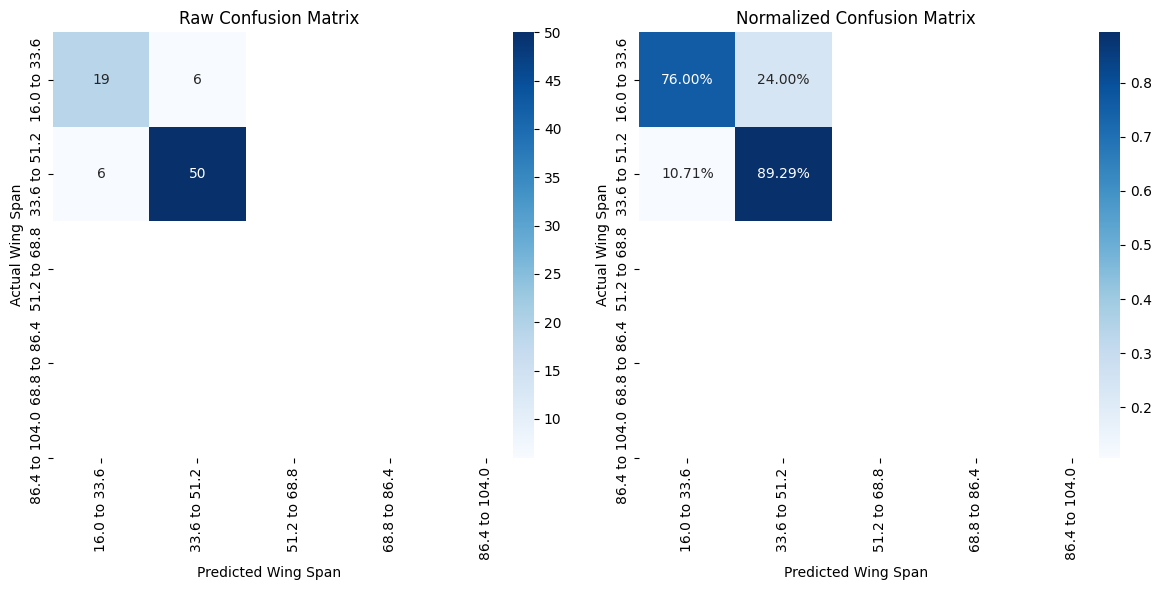

In [20]:
def create_confusion_matrix(y_test, predictions, bins, bin_labels):
    """
    Creates and visualizes both a normalized and raw confusion matrix by discretizing
    the continuous target and prediction values into bins.
    
    Parameters:
    -----------
    y_test : array-like
        The true values of the target variable (e.g., `Wing_Span`).
        
    predictions : array-like
        The predicted values of the target variable (e.g., predicted `Wing_Span`).
        
    bins : list
        A list of bin edges used to discretize the continuous values.
        
    bin_labels : list
        A list of labels for each bin, corresponding to the bin edges.
        
    Returns:
    --------
    None
    """
    
    # Discretize the actual values and predictions into the bins (using the bin edges)
    y_test_binned = pd.cut(y_test, bins=bins, labels=False, right=False)  # right=False makes bins left-inclusive
    predictions_binned = pd.cut(predictions, bins=bins, labels=False, right=False)
    
    # Calculate confusion matrix using numerical indices for bins
    cm = confusion_matrix(y_test_binned, predictions_binned)
    
    # Normalize the confusion matrix (by row, i.e., actual values)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize by row (actual values)
    
    # Create a figure with two subplots
    plt.figure(figsize=(12, 6))

    # Raw confusion matrix plot (without normalization)
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=bin_labels, yticklabels=bin_labels)
    plt.title('Raw Confusion Matrix')
    plt.xlabel('Predicted Wing Span')
    plt.ylabel('Actual Wing Span')

    # Normalized confusion matrix plot (percentage format)
    plt.subplot(1, 2, 2)
    sns.heatmap(cm_percentage, annot=True, fmt='.2%', cmap='Blues', xticklabels=bin_labels, yticklabels=bin_labels)
    plt.title('Normalized Confusion Matrix')
    plt.xlabel('Predicted Wing Span')
    plt.ylabel('Actual Wing Span')

    # Save the confusion matrix plot (both raw and normalized)
    plt.savefig("outputs/ml_pipeline/predict_analysis/confusion_matrix.png")

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()

    return cm, cm_percentage

def clean_data(y_test, predictions):
    """
    Cleans the input data by removing NaN or infinite values.
    
    Parameters:
    -----------
    y_test : array-like
        The true values of the target variable (e.g., `Wing_Span`).
        
    predictions : array-like
        The predicted values of the target variable (e.g., predicted `Wing_Span`).
        
    Returns:
    --------
    cleaned_y_test : array-like
        Cleaned true values of the target variable (no NaN or infinite values).
        
    cleaned_predictions : array-like
        Cleaned predicted values (no NaN or infinite values).
    """
    # Remove NaN or infinite values
    mask = np.isfinite(y_test) & np.isfinite(predictions)
    cleaned_y_test = y_test[mask]
    cleaned_predictions = predictions[mask]
    
    return cleaned_y_test, cleaned_predictions

# Example usage of the function:
min_wing_span = 16
max_wing_span = 104

# Create 5 equally spaced bins between the minimum and maximum values
bins_5 = np.linspace(min_wing_span, max_wing_span, 6)  # 6 edges = 5 bins
print("5 Bins Edges:", bins_5)

# Create bin labels based on the bin edges
bin_labels_5 = [f'{round(bins_5[i], 1)} to {round(bins_5[i+1], 1)}' for i in range(len(bins_5)-1)]
print("Bin Labels:", bin_labels_5)

# Check if y_test or predictions contain NaN or Inf values
print("Checking for NaN or Inf values in y_test:")
print(f"y_test contains NaN: {np.any(np.isnan(y_test))}")
print(f"y_test contains Inf: {np.any(np.isinf(y_test))}")

print("Checking for NaN or Inf values in predictions:")
print(f"predictions contains NaN: {np.any(np.isnan(predictions))}")
print(f"predictions contains Inf: {np.any(np.isinf(predictions))}")

# If any NaN or Inf values found, remove or replace them
valid_mask = ~np.isnan(y_test) & ~np.isinf(y_test) & ~np.isnan(predictions) & ~np.isinf(predictions)
y_test_clean = y_test[valid_mask]
predictions_clean = predictions[valid_mask]

# Call the function with the actual and predicted values
confusion_matrix_result, normalized_confusion_matrix = create_confusion_matrix(y_test_clean, predictions_clean, bins_5, bin_labels_5)

---

# Push files to the repo

The following plots has already been save upstream right after they where created:
* feature_importance (3 files) 
* Mean Squared Error
* Predicted vs Actual Plot
* Residuals Distribution Plot
* Residuals vs Fitted Plot

Below we will generate the following files:
* Train set
* Test set
* Modeling pipeline

In [21]:
joblib.dump(pipeline, 'outputs/ml_pipeline/predict_analysis/wingspan_predictor_model.pkl')


['outputs/ml_pipeline/predict_analysis/wingspan_predictor_model.pkl']

In [22]:
file_path = f'outputs/ml_pipeline/predict_analysis'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

[Errno 17] File exists: 'outputs/ml_pipeline/predict_analysis'


## Train Set: features and target

In [23]:
X_train.head()

,Length,Height,AUW,MEW,FW,Vmax,Vcruise,Vstall,Range,Hmax,ROC,Vlo,Slo,Vl,Sl
394,27.166667,8.833333,2550.0,1572.0,348.4,132.0,130.0,47.0,570.0,17000.0,870.0,1360.0,800.0,1345.0,635.0
685,29.000000,9.500000,3600.0,2071.0,629.8,189.0,175.0,61.0,648.0,20000.0,1050.0,1875.0,1410.0,1760.0,1050.0
550,23.500000,8.083333,2350.0,1520.0,201.0,123.0,117.0,45.0,305.0,13500.0,800.0,1375.0,650.0,900.0,475.0
141,25.083333,6.500000,2900.0,1820.0,261.3,179.0,165.0,50.0,470.0,19800.0,1225.0,1260.0,1050.0,1050.0,710.0
132,26.333333,6.500000,3400.0,2027.0,335.0,217.0,200.0,55.0,600.0,29500.0,1225.0,1320.0,950.0,1177.0,647.0


In [24]:
X_train.to_csv('outputs/ml_pipeline/predict_analysis/X_train.csv', index=False)

In [25]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [26]:
y_train

394    35.833333
685    32.833333
550    34.000000
141    32.750000
132    33.416667
         ...    
681    36.166667
396    36.083333
321    35.833333
61     44.333333
376    35.833333
Name: Wing_Span, Length: 321, dtype: float64

In [27]:
y_train.to_csv('outputs/ml_pipeline/predict_analysis/y_train.csv', index=False)

## Test Set: features and target

In [28]:
X_test.head()

,Length,Height,AUW,MEW,FW,Vmax,Vcruise,Vstall,Range,Hmax,ROC,Vlo,Slo,Vl,Sl
403,27.000000,9.916667,2220.0,1574.0,281.4,98.0,97.0,44.0,435.0,12000.0,715.0,2390.0,1620.0,1345.000000,590.0
821,22.250000,6.500000,1750.0,1040.0,268.0,109.0,100.0,42.0,296.0,18000.0,750.0,1140.0,720.0,1630.096648,500.0
136,26.333333,6.500000,3400.0,1915.0,335.0,183.0,177.0,55.0,543.0,17500.0,1136.0,1320.0,965.0,1177.000000,647.0
155,25.750000,8.083333,2750.0,1696.0,381.9,145.0,137.0,60.0,647.0,15385.0,927.0,1561.0,1063.0,1462.000000,816.0
142,25.083333,6.500000,2775.0,1722.0,261.3,169.0,160.0,48.0,550.0,19000.0,1300.0,1270.0,1060.0,1025.000000,680.0


In [29]:
X_test.to_csv('outputs/ml_pipeline/predict_analysis/X_test_head.csv', index=False)

In [30]:
y_test

403    35.833333
821    36.000000
136    33.416667
155    32.750000
142    32.750000
         ...    
27     27.000000
317    36.500000
21     35.666667
573    33.166667
683    36.166667
Name: Wing_Span, Length: 81, dtype: float64

In [31]:
y_test.to_csv('outputs/ml_pipeline/predict_analysis/y_test.csv', index=False)

---